# North American Herbivores - Image Classification using Keras and Tensorflow

In this project, we will be creating an image classification model to correctly identify herbivore speices that reside on the North American continent.

The species are the following:
    
    - Rocky Mountain Bighorn Sheep 
    - Moose
    - Pronghorn
    - American Bison
    - Mule Deer
    - White-tailed Deer
    - Rocky Mountain Elk
    
These animals reside in the same region of the Western United States and Southwestern Canada. A model like this can be deployed and be useful to a tourist in the many national parks in the West or anyone who is curious about and wants to properly identify wildlife.

The project will require the following steps:

- Get images from Google of each of the species.
- Pre-process the images for model building, specifically nueral networks.
- Build a Convolutional Neural Network.
- Fine tune the models.
- Deploy the best model - (possible deployments could be an iOS/Android app, etc.)

### Extracting Images from the Web

- Here, we will use the simple_image_download library but we could also use different methods such as Beautiful Soup or Selenium. Due to the simple and user-friendly functions, I decided to choose SID library.

In [2]:
#retrieve images from Google

from simple_image_download import simple_image_download as sid 
response = sid.simple_image_download

animals=['rocky mountain bighorn sheep', 'moose', 'pronghorn', 'american bison', 'mule deer', 'whitetail deer','rocky mountain elk']



for i in animals:
    response().download(i, 120)


[=========================================================================] 100%
[=========================================================================] 100%
[=========================================================================] 100%
[=========================================================================] 100%
[=========================================================================] 100%
[=========================================================================] 100%
[=========================================================================] 100%


In [3]:
#move folders out of simple images folder to the main folder

import shutil
import os
 
src = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/simple_images/'
dest = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/'
 
files = os.listdir(src)
 
for f in files:
    shutil.move(src + f, dest)

In [4]:
#let's rename all the image files in the folders to create consistency and make all the files .jpg as well

path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/'

animals=['rocky_mountain_bighorn_sheep', 'moose', 'pronghorn', 'american_bison', 'mule_deer', 'whitetail_deer','rocky_mountain_elk']



for x in animals:
    
    i = 0
    
    for filename in os.listdir(path+x):
        os.rename(os.path.join(path+x,filename), os.path.join(path+x,x+str(i)+'.jpg'))
        
        i = i +1

### Image Preprocessing

Image preprocessing is an important step since we need to decide whether we should transform the images, blur the images, resize them, etc. Making these decisions plays an important role in determining what the ML model will pick up and how effectively or how much memory we are using.

- Let's view some of the images we downloaded along with some information about them.

In [5]:
#import some packages

import cv2
from PIL import Image, ImageOps
import pandas as pd
import numpy as np

from scipy.stats import stats

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

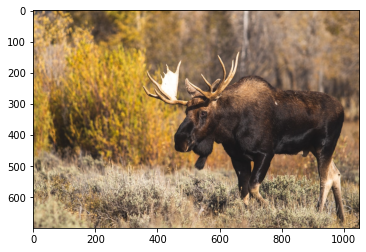

JPEG - (1050, 700) - RGB
Shape: (700, 1050, 3)
Memory in Bytes: 186559


In [6]:
path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/moose/moose0.jpg'

moose = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
plt.imshow(moose)
plt.show()

md = Image.open(path)

print(md.format,'-', md.size,'-', md.mode)
print('Shape:',cv2.imread(path).shape)
print ('Memory in Bytes:',os.stat(path).st_size)

### Image Resizing for Nueral Networks 

We can see that many of the images are of different sizes and some are very large. In order to speed up the time it takes for a model to run, we need to reduce the number of pixels that are processed which can be done by subsampling. We also need the images to be of the same size in order to feed the model the data. 


We will perform the following:
    
   - Write a function to resize the images while keeping the aspect ratio intact.

In [7]:
#let's create some empty folders in the current directory where we will have the new images stored 

main_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer'
  
for i in animals:
    path = os.path.join(main_path, 'Resized_'+i)
    os.mkdir(path)

In [8]:
#let's write a function to resize the images

def Resize_Images(inpath, outpath, image_size):
    for image_path in os.listdir(inpath):

        input_path = os.path.join(inpath, image_path)
        
        im = Image.open(input_path)
        old_size = im.size 

        ratio = float(image_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        im = im.resize(new_size, Image.ANTIALIAS)

        new_im = Image.new("RGB", (image_size, image_size))
        new_im.paste(im, ((image_size-new_size[0])//2,
                            (image_size-new_size[1])//2))
        
        fullpath = os.path.join(outpath, 'Resized_'+image_path)
        new_im.save(fullpath)

In [9]:
#puts all inpaths and outpaths into two separate lists

inpath = []

for i in animals:
    inpath.append(main_path+'/'+i)

outpath = []

for i in animals:
    outpath.append(main_path+'/Resized_'+i)

import itertools 

s = 200

#run the function for all the folders, in parallel for each species

for a, b in zip(inpath,outpath):
     Resize_Images(a,b,s)

/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/deer/lib/python3.8/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


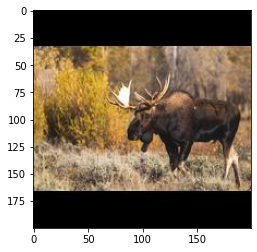

JPEG - (200, 200) - RGB
Shape: (200, 200, 3)
Memory in Bytes: 8809


In [10]:
#let's see what the new images look like

path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/Resized_moose/Resized_moose0.jpg'

moose = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
plt.imshow(moose)
plt.show()

md = Image.open(path)

print(md.format,'-', md.size,'-', md.mode)
print('Shape:',cv2.imread(path).shape)
print ('Memory in Bytes:',os.stat(path).st_size)

### Create a Training and Test Set

In [11]:
#make a training and testing folder with subfolders of each animal species - folders should have the same name in both training and testing folder

os.mkdir('training') 
os.mkdir('testing') 

train_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/training'
test_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/testing'
  
for i in animals:
    path = os.path.join(train_path, i)
    os.mkdir(path)
    
for i in animals:
    path = os.path.join(test_path, i)
    os.mkdir(path)

In [12]:
#put all inpaths and outpaths into 3 separate lists - one for the resized group, training group and testing group

resized_folders = []

root_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/Resized_'

for i in animals:
    resized_folders.append(root_path+i+'/')

testing_folders = []

root_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/testing/'

for i in animals:
    testing_folders.append(root_path+i+'/')
    
training_folders = []

root_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/training/'

for i in animals:
    training_folders.append(root_path+i+'/')

In [14]:
#let's write a function to randomly select images to put into testing subfolders

import random

def Randomized_Test_Set(resized_folders,testing_folders,test_size):
    
    for j in range(0,len(resized_folders)):
        
        file_list = os.listdir(resized_folders[j])
    
        i = 0
    
        while i<test_size:
        
            x = random.choice(file_list)
            shutil.move(resized_folders[j]+x, testing_folders[j]+x)
            file_list.remove(x)
        
            i=i+1

Randomized_Test_Set(resized_folders,testing_folders,20)

In [15]:
#let's write a function to move remaining images to training subfolders

def Create_Training_Set(resized_folders,training_folders):
    
    for j in range(0,len(resized_folders)):
        
        file_list = os.listdir(resized_folders[j])
    
        for f in file_list:

            shutil.move(resized_folders[j]+f, training_folders[j]+f)
            
            
Create_Training_Set(resized_folders,training_folders)

### Build a Convolutional Nueral Network

In [16]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [17]:
#scale the image data from a range of 0-255 to 0-1

train = ImageDataGenerator(rescale = 1/255)
test = ImageDataGenerator(rescale = 1/255)

In [18]:
train_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/training'

train_data = train.flow_from_directory(train_path,
                                       target_size=(200, 200),
                                       color_mode="rgb",
                                       batch_size= 15,
                                       class_mode="sparse")

test_path = '/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/testing'

test_data = test.flow_from_directory(test_path,
                                     target_size=(200, 200),
                                     color_mode="rgb",
                                     batch_size= 15,
                                     class_mode="sparse")

Found 700 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [19]:
train_data.class_indices

{'american_bison': 0,
 'moose': 1,
 'mule_deer': 2,
 'pronghorn': 3,
 'rocky_mountain_bighorn_sheep': 4,
 'rocky_mountain_elk': 5,
 'whitetail_deer': 6}

In [20]:
test_data.class_indices

{'american_bison': 0,
 'moose': 1,
 'mule_deer': 2,
 'pronghorn': 3,
 'rocky_mountain_bighorn_sheep': 4,
 'rocky_mountain_elk': 5,
 'whitetail_deer': 6}

In [21]:
#build a model

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',input_shape = (200,200,3)),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Flatten(),
                                   #
                                   tf.keras.layers.Dense(512,activation = 'relu'),
                                   #
                                   tf.keras.layers.Dense(7, activation = 'softmax')
                                   ])

2021-11-30 12:30:02.288377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
#compile the model

model.compile(loss='SparseCategoricalCrossentropy',
              optimizer = 'sgd',
              metrics=['accuracy'])

In [23]:
#fit the model on the training data and evaluate on the test data 

model_fit = model.fit(train_data,
                      steps_per_epoch = 3,
                      epochs = 500,
                      validation_data = test_data)

Epoch 1/500
3/3 [==============================] - 4s 2s/step - loss: 1.9410 - accuracy: 0.0667 - val_loss: 1.9591 - val_accuracy: 0.1429
Epoch 2/500
3/3 [==============================] - 3s 1s/step - loss: 1.9723 - accuracy: 0.1556 - val_loss: 1.9514 - val_accuracy: 0.1357
Epoch 3/500
3/3 [==============================] - 3s 1s/step - loss: 1.9447 - accuracy: 0.1333 - val_loss: 1.9492 - val_accuracy: 0.1786
Epoch 4/500
3/3 [==============================] - 3s 900ms/step - loss: 1.9389 - accuracy: 0.2000 - val_loss: 1.9512 - val_accuracy: 0.1357
Epoch 5/500
3/3 [==============================] - 2s 880ms/step - loss: 1.9494 - accuracy: 0.1556 - val_loss: 1.9483 - val_accuracy: 0.1429
Epoch 6/500
3/3 [==============================] - 2s 905ms/step - loss: 1.9506 - accuracy: 0.1778 - val_loss: 1.9463 - val_accuracy: 0.1286
Epoch 7/500
3/3 [==============================] - 2s 882ms/step - loss: 1.9444 - accuracy: 0.1556 - val_loss: 1.9460 - val_accuracy: 0.1357
Epoch 8/500
3/3 [=====

Epoch 59/500
3/3 [==============================] - 3s 1s/step - loss: 1.8115 - accuracy: 0.3333 - val_loss: 1.8173 - val_accuracy: 0.2929
Epoch 60/500
3/3 [==============================] - 2s 865ms/step - loss: 1.7671 - accuracy: 0.3556 - val_loss: 1.8528 - val_accuracy: 0.2286
Epoch 61/500
3/3 [==============================] - 2s 879ms/step - loss: 1.7308 - accuracy: 0.2889 - val_loss: 1.7886 - val_accuracy: 0.3357
Epoch 62/500
3/3 [==============================] - 2s 876ms/step - loss: 1.7844 - accuracy: 0.4889 - val_loss: 1.8048 - val_accuracy: 0.2571
Epoch 63/500
3/3 [==============================] - 2s 872ms/step - loss: 1.7578 - accuracy: 0.3556 - val_loss: 1.8113 - val_accuracy: 0.2357
Epoch 64/500
3/3 [==============================] - 2s 984ms/step - loss: 1.7466 - accuracy: 0.2222 - val_loss: 1.7941 - val_accuracy: 0.3143
Epoch 65/500
3/3 [==============================] - 2s 878ms/step - loss: 1.7653 - accuracy: 0.3556 - val_loss: 1.7618 - val_accuracy: 0.3071
Epoch 66/

3/3 [==============================] - 2s 893ms/step - loss: 1.1955 - accuracy: 0.5333 - val_loss: 1.4957 - val_accuracy: 0.4357
Epoch 174/500
3/3 [==============================] - 2s 874ms/step - loss: 0.8403 - accuracy: 0.7556 - val_loss: 1.4828 - val_accuracy: 0.4357
Epoch 175/500
3/3 [==============================] - 2s 876ms/step - loss: 0.9696 - accuracy: 0.6444 - val_loss: 1.6501 - val_accuracy: 0.3571
Epoch 176/500
3/3 [==============================] - 2s 900ms/step - loss: 0.7176 - accuracy: 0.7111 - val_loss: 1.6651 - val_accuracy: 0.4000
Epoch 177/500
3/3 [==============================] - 2s 916ms/step - loss: 0.9945 - accuracy: 0.6667 - val_loss: 1.5392 - val_accuracy: 0.4857
Epoch 178/500
3/3 [==============================] - 2s 914ms/step - loss: 0.8337 - accuracy: 0.7556 - val_loss: 1.4337 - val_accuracy: 0.4571
Epoch 179/500
3/3 [==============================] - 2s 876ms/step - loss: 0.9320 - accuracy: 0.6889 - val_loss: 1.4450 - val_accuracy: 0.4929
Epoch 180/500

3/3 [==============================] - 2s 888ms/step - loss: 0.1179 - accuracy: 0.9778 - val_loss: 2.0470 - val_accuracy: 0.5857
Epoch 288/500
3/3 [==============================] - 2s 880ms/step - loss: 0.0933 - accuracy: 0.9778 - val_loss: 1.1042 - val_accuracy: 0.7571
Epoch 289/500
3/3 [==============================] - 2s 873ms/step - loss: 0.1938 - accuracy: 0.9111 - val_loss: 1.4242 - val_accuracy: 0.7143
Epoch 290/500
3/3 [==============================] - 2s 874ms/step - loss: 0.2688 - accuracy: 0.8889 - val_loss: 1.0601 - val_accuracy: 0.7429
Epoch 291/500
3/3 [==============================] - 2s 817ms/step - loss: 0.0684 - accuracy: 0.9750 - val_loss: 1.1335 - val_accuracy: 0.7571
Epoch 292/500
3/3 [==============================] - 2s 868ms/step - loss: 0.0660 - accuracy: 0.9778 - val_loss: 1.2217 - val_accuracy: 0.7500
Epoch 293/500
3/3 [==============================] - 2s 872ms/step - loss: 0.0425 - accuracy: 1.0000 - val_loss: 1.1881 - val_accuracy: 0.7571
Epoch 294/500

3/3 [==============================] - 3s 1s/step - loss: 0.0742 - accuracy: 0.9778 - val_loss: 1.2447 - val_accuracy: 0.7714
Epoch 403/500
3/3 [==============================] - 3s 1s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.2656 - val_accuracy: 0.7714
Epoch 404/500
3/3 [==============================] - 3s 1s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2629 - val_accuracy: 0.7714
Epoch 405/500
3/3 [==============================] - 3s 1s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.2898 - val_accuracy: 0.7714
Epoch 406/500
3/3 [==============================] - 2s 1s/step - loss: 0.0761 - accuracy: 0.9778 - val_loss: 1.3768 - val_accuracy: 0.7714
Epoch 407/500
3/3 [==============================] - 3s 997ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.3200 - val_accuracy: 0.7714
Epoch 408/500
3/3 [==============================] - 3s 1s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3166 - val_accuracy: 0.7714
Epoch 409/500
3/3 [============

In [24]:
#let's add some more layers to this CNN and see if it performs better

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(5,5),activation = 'relu',input_shape = (200,200,3)),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Flatten(),
                                   #
                                   tf.keras.layers.Dense(512,activation = 'relu'),
                                   #
                                   tf.keras.layers.Dense(512,activation = 'relu'),
                                   #
                                   tf.keras.layers.Dense(7, activation = 'softmax')
                                   ])

In [25]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer = 'sgd',
              metrics=['accuracy'])

In [26]:
model_fit_1 = model.fit(train_data,
                      steps_per_epoch = 3,
                      epochs = 500,
                      validation_data = test_data)

Epoch 1/500
3/3 [==============================] - 3s 1s/step - loss: 1.9373 - accuracy: 0.2000 - val_loss: 1.9484 - val_accuracy: 0.1500
Epoch 2/500
3/3 [==============================] - 3s 1s/step - loss: 1.9561 - accuracy: 0.0667 - val_loss: 1.9481 - val_accuracy: 0.1500
Epoch 3/500
3/3 [==============================] - 3s 1s/step - loss: 1.9493 - accuracy: 0.1556 - val_loss: 1.9474 - val_accuracy: 0.1357
Epoch 4/500
3/3 [==============================] - 2s 1s/step - loss: 1.9516 - accuracy: 0.1333 - val_loss: 1.9469 - val_accuracy: 0.1357
Epoch 5/500
3/3 [==============================] - 3s 1s/step - loss: 1.9424 - accuracy: 0.3111 - val_loss: 1.9471 - val_accuracy: 0.1429
Epoch 6/500
3/3 [==============================] - 2s 995ms/step - loss: 1.9461 - accuracy: 0.1556 - val_loss: 1.9467 - val_accuracy: 0.1429
Epoch 7/500
3/3 [==============================] - 2s 993ms/step - loss: 1.9457 - accuracy: 0.1778 - val_loss: 1.9466 - val_accuracy: 0.1429
Epoch 8/500
3/3 [===========

Epoch 60/500
3/3 [==============================] - 2s 997ms/step - loss: 1.9308 - accuracy: 0.1333 - val_loss: 1.9254 - val_accuracy: 0.2571
Epoch 61/500
3/3 [==============================] - 3s 1s/step - loss: 1.9423 - accuracy: 0.2222 - val_loss: 1.9247 - val_accuracy: 0.2571
Epoch 62/500
3/3 [==============================] - 2s 988ms/step - loss: 1.9282 - accuracy: 0.2000 - val_loss: 1.9227 - val_accuracy: 0.2286
Epoch 63/500
3/3 [==============================] - 3s 1s/step - loss: 1.9135 - accuracy: 0.2750 - val_loss: 1.9234 - val_accuracy: 0.2000
Epoch 64/500
3/3 [==============================] - 2s 942ms/step - loss: 1.9077 - accuracy: 0.3000 - val_loss: 1.9268 - val_accuracy: 0.1929
Epoch 65/500
3/3 [==============================] - 2s 989ms/step - loss: 1.9381 - accuracy: 0.2444 - val_loss: 1.9232 - val_accuracy: 0.1714
Epoch 66/500
3/3 [==============================] - 2s 947ms/step - loss: 1.9109 - accuracy: 0.1750 - val_loss: 1.9249 - val_accuracy: 0.1714
Epoch 67/500

3/3 [==============================] - 3s 1s/step - loss: 1.7177 - accuracy: 0.2444 - val_loss: 1.7329 - val_accuracy: 0.2786
Epoch 177/500
3/3 [==============================] - 3s 1s/step - loss: 1.6736 - accuracy: 0.2889 - val_loss: 1.6725 - val_accuracy: 0.3500
Epoch 178/500
3/3 [==============================] - 3s 1s/step - loss: 1.6456 - accuracy: 0.4444 - val_loss: 1.6840 - val_accuracy: 0.2714
Epoch 179/500
3/3 [==============================] - 3s 1s/step - loss: 1.7102 - accuracy: 0.4000 - val_loss: 1.6931 - val_accuracy: 0.3286
Epoch 180/500
3/3 [==============================] - 3s 1s/step - loss: 1.5653 - accuracy: 0.4222 - val_loss: 1.6985 - val_accuracy: 0.2786
Epoch 181/500
3/3 [==============================] - 3s 1s/step - loss: 1.5129 - accuracy: 0.4222 - val_loss: 1.6576 - val_accuracy: 0.3286
Epoch 182/500
3/3 [==============================] - 3s 1s/step - loss: 1.3155 - accuracy: 0.5500 - val_loss: 1.7875 - val_accuracy: 0.2571
Epoch 183/500
3/3 [===============

3/3 [==============================] - 3s 1s/step - loss: 1.6859 - accuracy: 0.4000 - val_loss: 1.6169 - val_accuracy: 0.3929
Epoch 293/500
3/3 [==============================] - 3s 1s/step - loss: 1.1642 - accuracy: 0.6444 - val_loss: 1.5685 - val_accuracy: 0.4286
Epoch 294/500
3/3 [==============================] - 3s 1s/step - loss: 1.0070 - accuracy: 0.6889 - val_loss: 1.6588 - val_accuracy: 0.4357
Epoch 295/500
3/3 [==============================] - 2s 936ms/step - loss: 0.9326 - accuracy: 0.7250 - val_loss: 1.6322 - val_accuracy: 0.3571
Epoch 296/500
3/3 [==============================] - 2s 999ms/step - loss: 0.9149 - accuracy: 0.6889 - val_loss: 1.7714 - val_accuracy: 0.3643
Epoch 297/500
3/3 [==============================] - 3s 1s/step - loss: 1.3574 - accuracy: 0.4889 - val_loss: 1.5350 - val_accuracy: 0.4286
Epoch 298/500
3/3 [==============================] - 3s 1s/step - loss: 0.9610 - accuracy: 0.6667 - val_loss: 1.6173 - val_accuracy: 0.4071
Epoch 299/500
3/3 [=========

3/3 [==============================] - 3s 1s/step - loss: 0.3106 - accuracy: 0.9250 - val_loss: 1.6853 - val_accuracy: 0.5786
Epoch 409/500
3/3 [==============================] - 2s 1s/step - loss: 0.4095 - accuracy: 0.8750 - val_loss: 1.7756 - val_accuracy: 0.6214
Epoch 410/500
3/3 [==============================] - 3s 1s/step - loss: 0.4835 - accuracy: 0.8667 - val_loss: 1.2197 - val_accuracy: 0.6571
Epoch 411/500
3/3 [==============================] - 3s 1s/step - loss: 0.3545 - accuracy: 0.8889 - val_loss: 1.5966 - val_accuracy: 0.6286
Epoch 412/500
3/3 [==============================] - 3s 1s/step - loss: 0.3863 - accuracy: 0.9111 - val_loss: 1.3185 - val_accuracy: 0.6571
Epoch 413/500
3/3 [==============================] - 3s 1s/step - loss: 0.2008 - accuracy: 0.9333 - val_loss: 1.2759 - val_accuracy: 0.7143
Epoch 414/500
3/3 [==============================] - 3s 1s/step - loss: 0.5893 - accuracy: 0.7778 - val_loss: 1.2736 - val_accuracy: 0.6214
Epoch 415/500
3/3 [===============

Epoch 466/500
3/3 [==============================] - 2s 981ms/step - loss: 0.0520 - accuracy: 1.0000 - val_loss: 1.3084 - val_accuracy: 0.7857
Epoch 467/500
3/3 [==============================] - 2s 978ms/step - loss: 0.1743 - accuracy: 0.9556 - val_loss: 1.3465 - val_accuracy: 0.7571
Epoch 468/500
3/3 [==============================] - 2s 983ms/step - loss: 0.0503 - accuracy: 1.0000 - val_loss: 1.5570 - val_accuracy: 0.7214
Epoch 469/500
3/3 [==============================] - 2s 976ms/step - loss: 0.1455 - accuracy: 0.9333 - val_loss: 1.3906 - val_accuracy: 0.7643
Epoch 470/500
3/3 [==============================] - 2s 986ms/step - loss: 0.1677 - accuracy: 0.9556 - val_loss: 1.4633 - val_accuracy: 0.7214
Epoch 471/500
3/3 [==============================] - 2s 994ms/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 1.3174 - val_accuracy: 0.7643
Epoch 472/500
3/3 [==============================] - 3s 1s/step - loss: 0.0729 - accuracy: 0.9778 - val_loss: 1.4060 - val_accuracy: 0.7357
Ep

### Transfer Learning 

Transfer learning is a machine learning technique where we use a pre-trained model on a different dataset to help us solve our somewhat similar problem. The network architecture and weights that were trained a huge dataset with many classes may help us extracting more features and increase our validation accuracy. 

It is generally a good idea to apply transfer learning when your dataset is small, which is what we have here.

In [27]:
#let's use the weights from imagenet nueral network

base_model = tf.keras.applications.MobileNetV2(input_shape = (250, 250, 3), include_top = False, weights = "imagenet")

In [28]:
#freeze our weights so it doesn't update during training

base_model.trainable = False

In [29]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(7, activation="softmax")                                     
                                ])

In [30]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model_fit_2 = model.fit(train_data,
                      steps_per_epoch = 3,
                      epochs = 500,
                      validation_data = test_data)

Epoch 1/500


/Users/matthew_macwan/Downloads/CIS/I_Class_Deer/deer/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 8s 2s/step - loss: 2.6458 - accuracy: 0.0889 - val_loss: 2.1089 - val_accuracy: 0.1929
Epoch 2/500
3/3 [==============================] - 4s 2s/step - loss: 2.2794 - accuracy: 0.1111 - val_loss: 1.8364 - val_accuracy: 0.2429
Epoch 3/500
3/3 [==============================] - 4s 2s/step - loss: 1.6916 - accuracy: 0.3778 - val_loss: 1.7518 - val_accuracy: 0.3357
Epoch 4/500
3/3 [==============================] - 4s 2s/step - loss: 1.8498 - accuracy: 0.3556 - val_loss: 1.5168 - val_accuracy: 0.4643
Epoch 5/500
3/3 [==============================] - 4s 2s/step - loss: 1.9232 - accuracy: 0.3556 - val_loss: 1.6693 - val_accuracy: 0.3500
Epoch 6/500
3/3 [==============================] - 4s 2s/step - loss: 1.6272 - accuracy: 0.4667 - val_loss: 1.3168 - val_accuracy: 0.5000
Epoch 7/500
3/3 [==============================] - 4s 2s/step - loss: 1.1827 - accuracy: 0.5111 - val_loss: 1.1874 - val_accuracy: 0.5714
Epoch 8/500
3/3 [=============================

3/3 [==============================] - 4s 2s/step - loss: 0.3650 - accuracy: 0.8889 - val_loss: 0.4515 - val_accuracy: 0.8857
Epoch 61/500
3/3 [==============================] - 4s 2s/step - loss: 0.4965 - accuracy: 0.7778 - val_loss: 0.4516 - val_accuracy: 0.8929
Epoch 62/500
3/3 [==============================] - 4s 2s/step - loss: 0.3792 - accuracy: 0.8667 - val_loss: 0.4581 - val_accuracy: 0.8714
Epoch 63/500
3/3 [==============================] - 4s 2s/step - loss: 0.3828 - accuracy: 0.9000 - val_loss: 0.4320 - val_accuracy: 0.8643
Epoch 64/500
3/3 [==============================] - 4s 2s/step - loss: 0.3772 - accuracy: 0.8667 - val_loss: 0.4147 - val_accuracy: 0.9000
Epoch 65/500
3/3 [==============================] - 4s 2s/step - loss: 0.4875 - accuracy: 0.8889 - val_loss: 0.4297 - val_accuracy: 0.8857
Epoch 66/500
3/3 [==============================] - 4s 2s/step - loss: 0.4357 - accuracy: 0.9111 - val_loss: 0.4447 - val_accuracy: 0.8714
Epoch 67/500
3/3 [======================

Epoch 119/500
3/3 [==============================] - 4s 2s/step - loss: 0.2065 - accuracy: 0.9556 - val_loss: 0.3298 - val_accuracy: 0.9357
Epoch 120/500
3/3 [==============================] - 4s 2s/step - loss: 0.2141 - accuracy: 0.9778 - val_loss: 0.3343 - val_accuracy: 0.9214
Epoch 121/500
3/3 [==============================] - 4s 2s/step - loss: 0.2758 - accuracy: 0.9333 - val_loss: 0.3374 - val_accuracy: 0.9143
Epoch 122/500
3/3 [==============================] - 4s 2s/step - loss: 0.2865 - accuracy: 0.9333 - val_loss: 0.3296 - val_accuracy: 0.9214
Epoch 123/500
3/3 [==============================] - 4s 2s/step - loss: 0.3229 - accuracy: 0.8750 - val_loss: 0.3473 - val_accuracy: 0.9214
Epoch 124/500
3/3 [==============================] - 4s 2s/step - loss: 0.2785 - accuracy: 0.9111 - val_loss: 0.3283 - val_accuracy: 0.9214
Epoch 125/500
3/3 [==============================] - 4s 2s/step - loss: 0.2084 - accuracy: 0.9333 - val_loss: 0.3386 - val_accuracy: 0.9286
Epoch 126/500
3/3 [=

3/3 [==============================] - 4s 2s/step - loss: 0.1814 - accuracy: 0.9556 - val_loss: 0.2640 - val_accuracy: 0.9571
Epoch 236/500
3/3 [==============================] - 4s 2s/step - loss: 0.1642 - accuracy: 0.9556 - val_loss: 0.2533 - val_accuracy: 0.9571
Epoch 237/500
3/3 [==============================] - 4s 2s/step - loss: 0.1738 - accuracy: 0.9556 - val_loss: 0.2581 - val_accuracy: 0.9500
Epoch 238/500
3/3 [==============================] - 4s 2s/step - loss: 0.1270 - accuracy: 0.9778 - val_loss: 0.2660 - val_accuracy: 0.9357
Epoch 239/500
3/3 [==============================] - 4s 2s/step - loss: 0.2478 - accuracy: 0.9556 - val_loss: 0.2637 - val_accuracy: 0.9500
Epoch 240/500
3/3 [==============================] - 4s 2s/step - loss: 0.1268 - accuracy: 0.9556 - val_loss: 0.2723 - val_accuracy: 0.9357
Epoch 241/500
3/3 [==============================] - 4s 2s/step - loss: 0.1084 - accuracy: 0.9778 - val_loss: 0.2719 - val_accuracy: 0.9500
Epoch 242/500
3/3 [===============

3/3 [==============================] - 4s 2s/step - loss: 0.1115 - accuracy: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.9500
Epoch 352/500
3/3 [==============================] - 4s 2s/step - loss: 0.2056 - accuracy: 0.9556 - val_loss: 0.2194 - val_accuracy: 0.9571
Epoch 353/500
3/3 [==============================] - 4s 2s/step - loss: 0.1166 - accuracy: 0.9778 - val_loss: 0.2138 - val_accuracy: 0.9571
Epoch 354/500
3/3 [==============================] - 5s 2s/step - loss: 0.1427 - accuracy: 0.9556 - val_loss: 0.2131 - val_accuracy: 0.9571
Epoch 355/500
3/3 [==============================] - 5s 2s/step - loss: 0.0899 - accuracy: 0.9778 - val_loss: 0.2243 - val_accuracy: 0.9500
Epoch 356/500
3/3 [==============================] - 4s 2s/step - loss: 0.1722 - accuracy: 0.9556 - val_loss: 0.2162 - val_accuracy: 0.9571
Epoch 357/500
3/3 [==============================] - 4s 2s/step - loss: 0.1344 - accuracy: 0.9778 - val_loss: 0.2163 - val_accuracy: 0.9571
Epoch 358/500
3/3 [===============

3/3 [==============================] - 4s 2s/step - loss: 0.0611 - accuracy: 1.0000 - val_loss: 0.2139 - val_accuracy: 0.9571
Epoch 468/500
3/3 [==============================] - 4s 2s/step - loss: 0.1187 - accuracy: 0.9778 - val_loss: 0.2232 - val_accuracy: 0.9357
Epoch 469/500
3/3 [==============================] - 4s 2s/step - loss: 0.1508 - accuracy: 0.9556 - val_loss: 0.2113 - val_accuracy: 0.9571
Epoch 470/500
3/3 [==============================] - 4s 2s/step - loss: 0.1196 - accuracy: 0.9778 - val_loss: 0.2156 - val_accuracy: 0.9571
Epoch 471/500
3/3 [==============================] - 4s 2s/step - loss: 0.1055 - accuracy: 0.9556 - val_loss: 0.2145 - val_accuracy: 0.9571
Epoch 472/500
3/3 [==============================] - 4s 2s/step - loss: 0.1522 - accuracy: 0.9778 - val_loss: 0.2091 - val_accuracy: 0.9571
Epoch 473/500
3/3 [==============================] - 4s 2s/step - loss: 0.1432 - accuracy: 1.0000 - val_loss: 0.2185 - val_accuracy: 0.9571
Epoch 474/500
3/3 [===============

### Model Evaluation

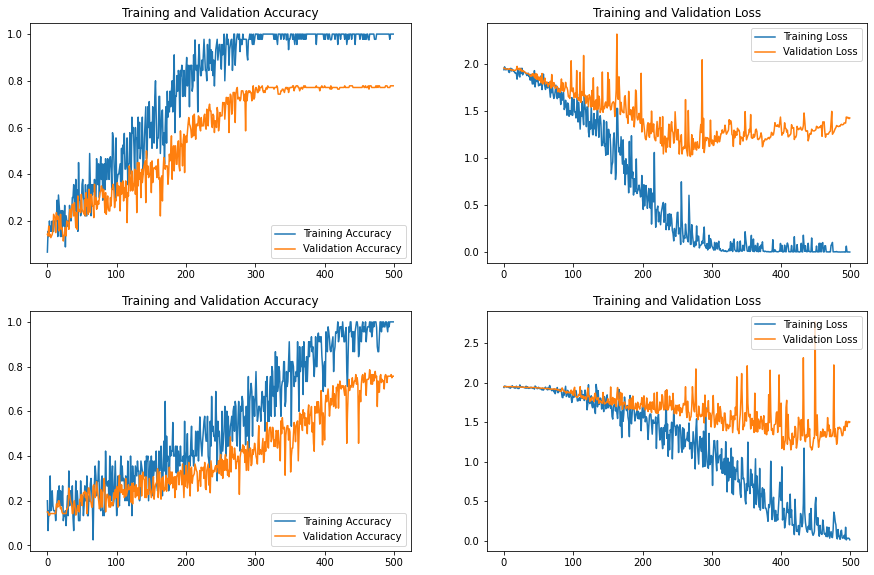

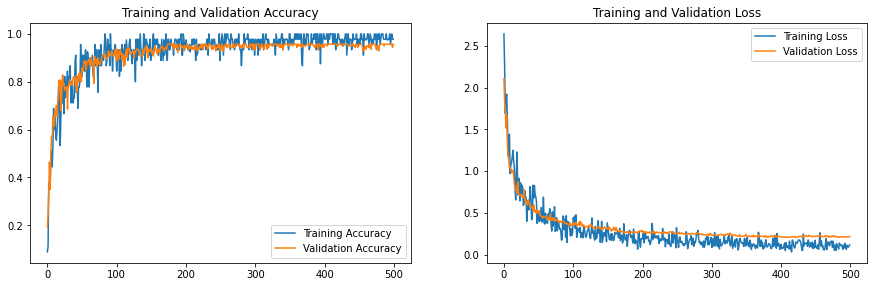

In [33]:
#First CNN

acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#Second CNN  

acc_1 = model_fit_1.history['accuracy']
val_acc_1 = model_fit_1.history['val_accuracy']
loss_1 = model_fit_1.history['loss']
val_loss_1 = model_fit_1.history['val_loss']
epochs_range_1 = range(500)

plt.subplot(3, 2, 3)
plt.plot(epochs_range_1, acc_1, label='Training Accuracy')
plt.plot(epochs_range_1, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 2, 4)
plt.plot(epochs_range_1, loss_1, label='Training Loss')
plt.plot(epochs_range_1, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#CNN with Transfer Learning 

acc_2 = model_fit_2.history['accuracy']
val_acc_2 = model_fit_2.history['val_accuracy']
loss_2 = model_fit_2.history['loss']
val_loss_2 = model_fit_2.history['val_loss']
epochs_range_2 = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 5)
plt.plot(epochs_range_2, acc_2, label='Training Accuracy')
plt.plot(epochs_range_2, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 2, 6)
plt.plot(epochs_range_2, loss_2, label='Training Loss')
plt.plot(epochs_range_2, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Analysis 

- We started off with the first CNN (2 hidden layers and 2 dense layers) - achieving a validation accuracy of around 0.77. 



- The idea I had in the second CNN was to add (2 hidden layers and 1 dense layer), increasing the kernel size in the first layer to (5,5) in order to pick up on larger features such as color blobs or edges. However, it ended up performing similarly to the less complex first CNN. Achieving a validation accuracy around 0.751

- The second CNN does not seem to plateau at 500 epochs, maybe training to 1000 epochs will allow for us to see a plateau in accuracy or loss and maybe it ends up with a higher validation accuracy.





Side Note: We see that the training accuracy is high in the first 2 CNN, we are probably overfitting our data. Some regularization techniques may help improve the model accuracy.






- The final CNN, involved transfer learning was the best, we brought in a base model from imagenet and added an Average Pooling layer and a dropout layer. Achieving a validation accuracy of 0.95. It also learns much quicker than the first 2 CNN, plateauing at around 200 epochs.


As a general rule of thumb, keep increasing the number of layers in a nueral network until we see that the loss isn't going down anymore or the validation accuracy starts to decrease. There are many factors involved with tuning a nueral network. 

Here are some of the following ways we can improve this model :

   - Data augmentation - we can flip or rotate the images we already have in our dataset to invent more data to train the model on.
   - Add more data - this is an obvious one, but comes with a higher computational cost. 
   - Experiment with different architecture - more layers, wide networks, deep networks, - no one knows the answer to the optimal number of layers in a network, it is best to experiment with many different types.
        

Overall, with less than 1000 images in the training set (pretty small dataset), we were still able to acheive a validation accuracy of 95% which is very satisfactory. Some tuning may help boost the model by 2-3%.